In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
from utils import moveTo

/tmp/ipykernel_23091/2224870203.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def train_simple_network(model, loss_func, training_loader, epochs=20, device="gpu"):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(training_loader, desc="Batch", leave=False):
            inputs = moveTo(inputs, device)
            labels = moveTo(labels, device)
            optimizer.zero_grad()
            y_hat = model(inputs)
            loss = loss_func(y_hat, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


<Axes: >

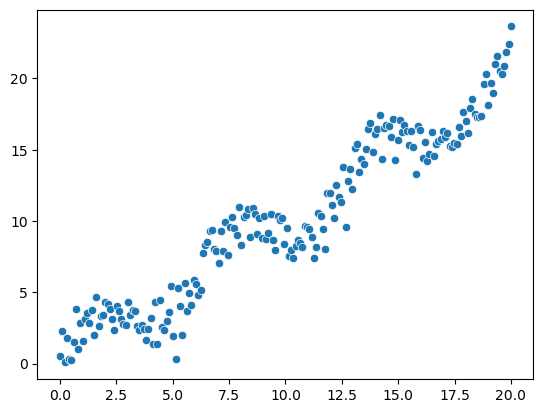

In [3]:
X = np.linspace(0, 20, num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)
sns.scatterplot(x=X, y=y)

In [4]:
class Simple1DRegressionDataset(Dataset):
    def __init__(self, X, y):
        super(Simple1DRegressionDataset, self).__init__()
        self.X = X.reshape(-1, 1)
        self.y = y.reshape(-1, 1)

    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
training_loader = DataLoader(Simple1DRegressionDataset(X, y), shuffle=True)

In [5]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 1)
)
loss_func = nn.MSELoss()

device = torch.device("cuda")
train_simple_network(model, loss_func, training_loader, device=device)

Epoch: 100%|██████████| 20/20 [00:01<00:00, 11.15it/s]


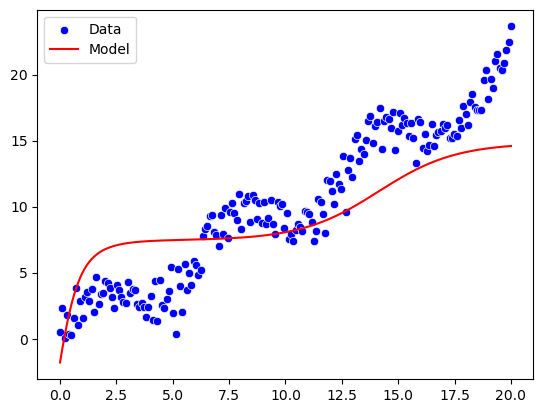

In [6]:
with torch.no_grad():
    Y_pred = model(torch.tensor(X.reshape(-1, 1), device=device, dtype=torch.float32)).cpu().numpy()
    sns.scatterplot(x=X, y=y, color='blue', label='Data')
    sns.lineplot(x=X, y=Y_pred.ravel(), color='red', label='Model')

### Classification

<Axes: >

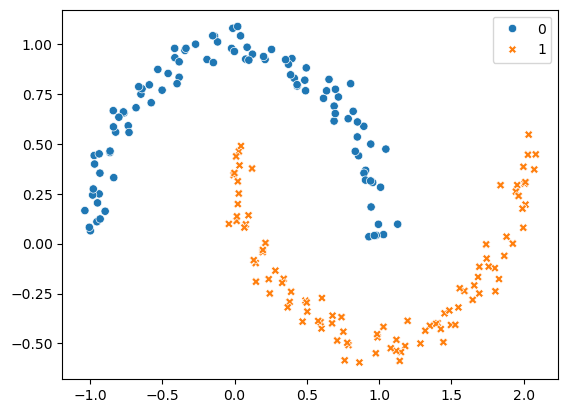

In [7]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y)

In [8]:
classification_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32),
    torch.tensor(y, dtype=torch.long)
)
training_loader = DataLoader(classification_dataset)

In [9]:
model = nn.Linear(2, 2)
loss_func = nn.CrossEntropyLoss()
train_simple_network(model, loss_func, training_loader, epochs=200, device=device)

Epoch: 100%|██████████| 200/200 [00:12<00:00, 16.42it/s]


Function is being called...
xv shape: (20, 20), yv shape: (20, 20)
xy_v shape: (400, 2)
Model is on device: cuda:0
logits shape: torch.Size([400, 2])
logits sample: tensor([[-1.5832,  1.4169],
        [-1.3075,  1.1207],
        [-1.0317,  0.8245],
        [-0.7560,  0.5284],
        [-0.4803,  0.2322]], device='cuda:0')
y_hat shape: (400, 2)
y_hat sample: [[0.04742274 0.9525773 ]
 [0.0810489  0.91895103]
 [0.13513592 0.86486405]
 [0.2168018  0.7831982 ]
 [0.32904375 0.67095625]]


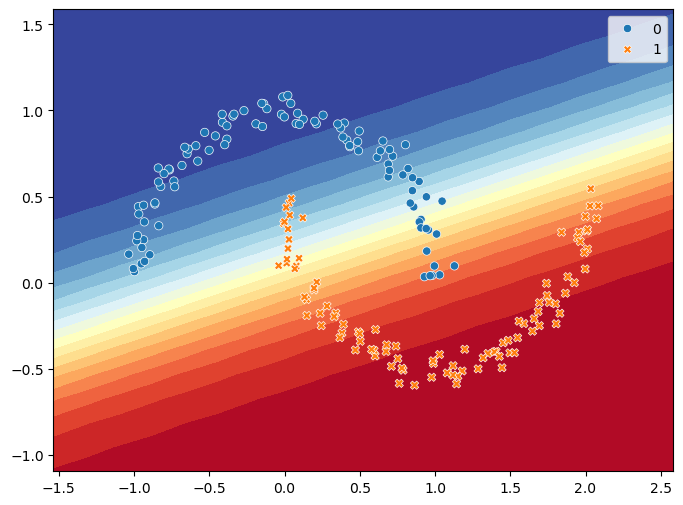

In [10]:
# Annotated by ChatGPT 4o

def visualize2DSoftmax(X, y, model, title=None):
    print("Function is being called...")

    x_min = np.min(X[:,0])-0.5
    x_max = np.max(X[:,0])+0.5
    y_min = np.min(X[:,1])-0.5
    y_max = np.max(X[:,1])+0.5

    xv, yv = np.meshgrid(np.linspace(x_min, x_max, num=20),
                          np.linspace(y_min, y_max, num=20), indexing='ij')
    xy_v = np.hstack((xv.reshape(-1,1), yv.reshape(-1,1)))

    print(f"xv shape: {xv.shape}, yv shape: {yv.shape}")
    print(f"xy_v shape: {xy_v.shape}")

    # Detect model's device (CPU or CUDA)
    device = next(model.parameters()).device
    print(f"Model is on device: {device}")

    with torch.no_grad():
        logits = model(torch.tensor(xy_v, dtype=torch.float32).to(device))  # Move input tensor to model's device
        print(f"logits shape: {logits.shape}")
        print(f"logits sample: {logits[:5]}")

        y_hat = F.softmax(logits, dim=1).cpu().numpy()  # Ensure tensor is moved to CPU before converting to NumPy
        print(f"y_hat shape: {y_hat.shape}")
        print(f"y_hat sample: {y_hat[:5]}")

    plt.figure(figsize=(8, 6))  # Ensure a new figure is created

    plt.contourf(xv, yv, y_hat[:,0].reshape(20,20),
                 levels=np.linspace(0,1,num=20), cmap=plt.cm.RdYlBu)

    ax = plt.gca()
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax)
    if title is not None:
        ax.set_title(title)

visualize2DSoftmax(X, y, model)

In [11]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
train_simple_network(model, loss_func, training_loader, epochs=250, device="cuda")

Epoch: 100%|██████████| 250/250 [00:23<00:00, 10.56it/s]


Function is being called...
xv shape: (20, 20), yv shape: (20, 20)
xy_v shape: (400, 2)
Model is on device: cuda:0
logits shape: torch.Size([400, 2])
logits sample: tensor([[-1.8148,  1.8788],
        [-1.4936,  1.5112],
        [-1.1495,  1.1199],
        [-0.7878,  0.7113],
        [-0.4156,  0.2932]], device='cuda:0')
y_hat shape: (400, 2)
y_hat sample: [[0.02427976 0.97572017]
 [0.04721143 0.9527886 ]
 [0.09369349 0.9063065 ]
 [0.18256758 0.81743246]
 [0.3298599  0.6701401 ]]


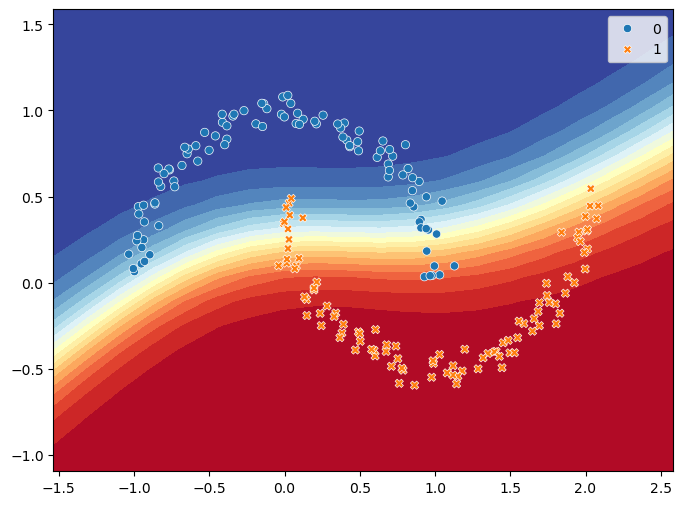

In [12]:
visualize2DSoftmax(X, y, model)

In [26]:
from utils import train_simple_network
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import TensorDataset

X_train, y_train = make_moons(n_samples=8000, noise=0.4)
X_test, y_test = make_moons(n_samples=200, noise=0.4)
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))
training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
)

results_pd = train_simple_network(model, loss_func, training_loader, testing_loader,
                                  epochs=5, checkpoint_file='model.pt',
                                  score_funcs={'Acc': accuracy_score, 'F1': f1_score})

Epoch: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


Function is being called...
xv shape: (20, 20), yv shape: (20, 20)
xy_v shape: (400, 2)
Model is on device: cpu
logits shape: torch.Size([400, 2])
logits sample: tensor([[ 0.0228, -0.1922],
        [-0.0043, -0.2143],
        [-0.0339, -0.2366],
        [-0.0657, -0.2589],
        [-0.0990, -0.2809]])
y_hat shape: (400, 2)
y_hat sample: [[0.55354345 0.44645658]
 [0.55230236 0.44769767]
 [0.5504847  0.44951525]
 [0.5481352  0.45186475]
 [0.54534596 0.45465404]]


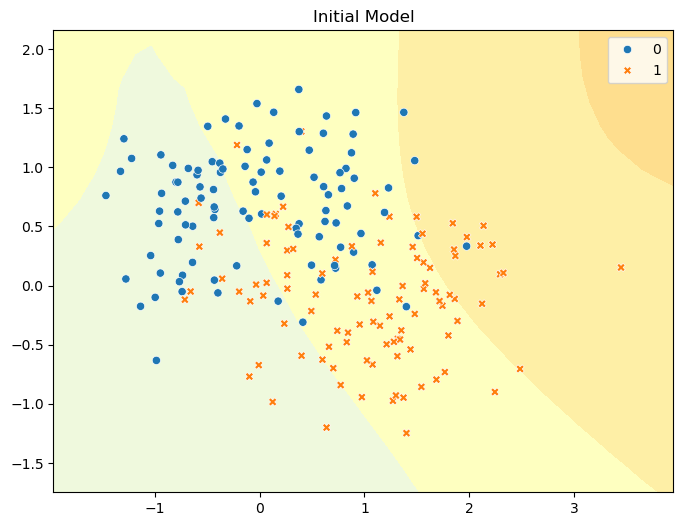

Function is being called...
xv shape: (20, 20), yv shape: (20, 20)
xy_v shape: (400, 2)
Model is on device: cpu
logits shape: torch.Size([400, 2])
logits sample: tensor([[-1.0755,  0.9156],
        [-0.8276,  0.6862],
        [-0.5509,  0.4327],
        [-0.2535,  0.1618],
        [ 0.0529, -0.1166]])
y_hat shape: (400, 2)
y_hat sample: [[0.12013907 0.87986094]
 [0.18037267 0.81962734]
 [0.2721771  0.7278229 ]
 [0.39763805 0.6023619 ]
 [0.54227173 0.45772827]]


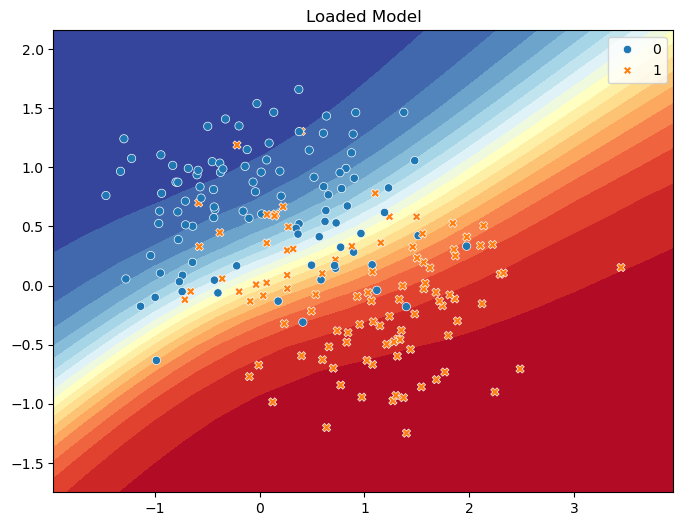

In [18]:
model_new = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
)
visualize2DSoftmax(X_test, y_test, model_new, title='Initial Model')
plt.show()
checkpoint_dict = torch.load('model.pt', map_location=device, weights_only=False)
model_new.load_state_dict(checkpoint_dict['model_state_dict'])
visualize2DSoftmax(X_test, y_test, model_new, title='Loaded Model')
plt.show()

In [19]:
results_pd

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,1.950024,0.422513,0.381840,0.816625,0.830,0.821901,0.826531
1,1,3.866668,0.383939,0.380080,0.832500,0.835,0.833333,0.832487
2,2,5.743233,0.382580,0.380958,0.834750,0.840,0.835695,0.836735
3,3,7.604251,0.381757,0.376269,0.834625,0.840,0.835058,0.838384
4,4,9.522477,0.380430,0.376997,0.833625,0.840,0.834597,0.836735


<Axes: xlabel='epoch', ylabel='train Acc'>

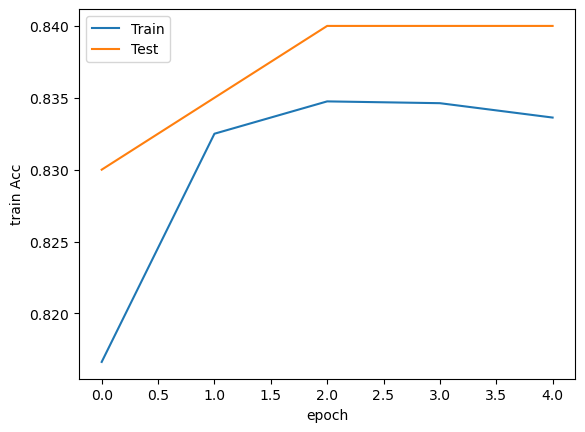

In [23]:
sns.lineplot(x='epoch', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='epoch', y='test Acc', data=results_pd, label='Test')

<Axes: xlabel='total time', ylabel='train F1'>

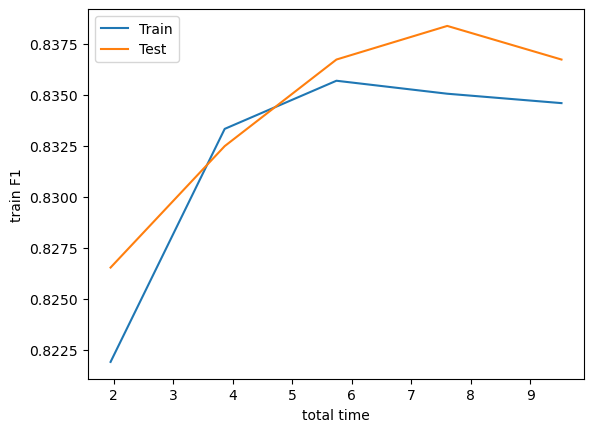

In [21]:
sns.lineplot(x='total time', y='train F1', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test F1', data=results_pd, label='Test')

### Gradient Descent and n-Batch SGD

In [39]:
training_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

model_gd = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
)

results_true_gd = train_simple_network(model_gd, loss_func, training_loader, testing_loader,
                                  epochs=5, checkpoint_file='model.pt', device="cuda",
                                  score_funcs={'Acc': accuracy_score, 'F1': f1_score})

Epoch: 100%|██████████| 5/5 [00:00<00:00, 16.29it/s]


In [40]:
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model_sgd = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
)

results_sgd_32 = train_simple_network(model_gd, loss_func, training_loader, testing_loader,
                                  epochs=5, checkpoint_file='model.pt', device="cuda",
                                  score_funcs={'Acc': accuracy_score, 'F1': f1_score})

Epoch: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


<Axes: xlabel='total time', ylabel='test Acc'>

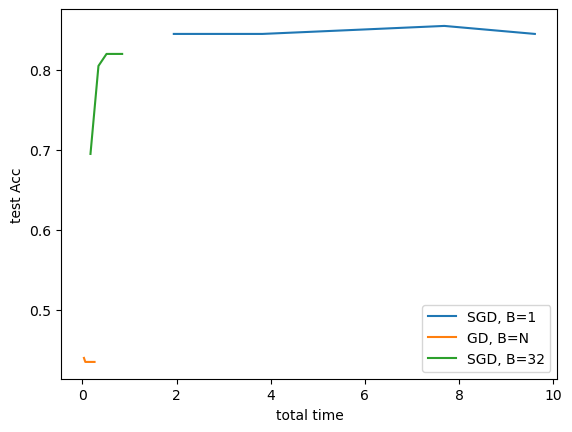

In [41]:
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='SGD, B=1')
sns.lineplot(x='total time', y='test Acc', data=results_true_gd, label='GD, B=N')
sns.lineplot(x='total time', y='test Acc', data=results_sgd_32, label='SGD, B=32')